In [28]:
#Importing libraries
library(tidyverse) #The mother of all analysis packages
library(rvest) #Scraping web pages
library(httr) #Lets us use requests for data from APIs
library(tidyr) #Functions to help keep our data tidy
library(magrittr) #Piping
library(purrr) #Useful functions for general df wrangling, especially for functions
library(glue) #Gives us useful functions for strings
library(stringr) #More useful functions for strings
library(polite) #For web scraping
library(xml2) #Allows us to work with xml files obtained through scraping
library(GGally) #Produces handy scatterplot matrix with correlations between columns in a dataframe
library(leaps) #Contains regsubsets() to help us select predictors for our model
library(car) #Contains AIC, which we're using for model analysis
library("jsonlite") #Gives functions to help us work with json from API request content
library(plotly) #Allows us to develop interactive graphs - compatible with ggplot2
library(ggthemr) #Extra nice-looking themes for ggplot2 graphs
library(tm) #Contains the function which allows us to remove numbers from a string
ggthemr('dust') #Sets the themes for our plots

In [29]:
#Scraping and wrangling OECD minimum wage data
minimum_wage_url = "https://stats.oecd.org/index.aspx?DataSetCode=RMW" #Defines our the main url we will use for scraping
mw_page = read_html(minimum_wage_url) #Reads in the html body from the webpage
countries1 = mw_page %>% html_nodes(xpath = '//*[@class="RowDimLabel"]') %>% html_text()
countries1 = countries1[seq(1, length(countries1), 2)]
#Reads in the first selector of countriesfrom html - removes unwanted values

countries2 = mw_page %>% html_nodes(xpath = '//*[@class="RowDimLabel2"]') %>% html_text()
countries2 = countries2[seq(1, length(countries2), 2)]
#Reads in the second selector of countries from html - removes unwanted values

data1 = mw_page %>% html_nodes(xpath = '//*[@class="Data"]') %>% html_text()
data2 = mw_page %>% html_nodes(xpath = '//*[@class="Data2"]') %>% html_text()
#Same as above but for the data values themselves
#We had two different selectors for these values due to them being defined as distinct rows in the html - even numbered rows had
#2 appended to the end of their class name. This created an opportunity to showcase some wrangling and cleaning skills.

mergeCountries = function(array1, array2) {
    output = array()
    for (num in seq.int(1, length(array1))){ #For each item in array
        output = output %>% append(c(array1[num], array2[num])) #Adds the values in order together as they appear
    }
    return(na.omit(output))
}
#Creates a function to merge the two vectors of country names together
#It's crucial that the countries are in the right order, as otherwise our data won't be matched to the right country

countries = mergeCountries(countries1, countries2)

for (i in seq.int(1, length(countries))){
    if (countries[i] == 'Korea'){
        countries[i] = 'South Korea'
    }
}
#In the OECD Stats datasets in particular - South Korea was called Korea, which preventing joins, as they had different values.
#This for loop just checks for 'Korea' in the array of countries and changes it to South Korea, allowing us to join
#this dataframe with the others.


step = 21
mw_data = as.vector(sapply(0 : (length(data1) / step - 1),
                    function(idx){
                        c(data1[1 : step+(idx * step)], data2[1:step + (idx*step)])}))
#Above code found on Stack Overflow (https://stackoverflow.com/questions/53480275/merge-two-arrays-in-r-alternating-their-elements) - merges the arrays of the data associated with the
#two different xpath selectors together, in the correct order (as we did with the countries). Altered the code to use only one step with its value at 21 - as this is the number of
#columns for one row.


remove_every_21st = function(array) {
    output = array[seq(1, length(array), 21)]
    array = array[2:length(array)]
    outputs = list(output, array)
    return(outputs)
}
#Takes every 21st value of our scraped data (which is every country's value for one year, the plan is to repeat this
#for every year column, as the data is in a wide format with individual years as columns), then returns the output array and
#the original array containing all data. We will maintain this wide format when creating the dataframe, then simply use the
#pivot_longer function to easily convert it into the long format.

outputs = remove_every_21st(mw_data) #First application of our function to the data, returns the 2001 data and the remaining
#data with 2001 removed
mw_list_2001 = unlist(outputs[1]) #2001 data
next_set = unlist(outputs[2]) #remaining

output = mw_list_2001

#The following is a recursive function to reorder the data into years - so it can be easily extracted into our dataframe
#Currently, it's in the form: aus2001 aus2002 aus2003 aus2004..... aus2020 bel2001..
#We want it in the form aus2001 bel2001 ..... so it can be more easily assigned to yearly variables, then melted from wide
#to long format
reorder = function(array, output) {
    if (length(output) < length(array)) {
        lists = remove_every_21st(array) #Applies previous function
        leftover = unlist(lists[2]) #Remaining data to be reordered
        useful = unlist(lists[1]) #The useful data we've extracted (one year's observations)
        output = c(output, useful) #Adds useful data to our output
        return(reorder(leftover, output)) #Recursively calls the function again - each call = 1 more year of data added to
        #the output
    }
    return(output) #Returns the reordered data, now we can turn it into a dataframe, then convert it into a long format easily
}

mw_data = reorder(next_set, mw_list_2001)

index=1
x1=1
x2=32

#Function to create the dataframe - uses dynamic variable naming for years and gsub function to remove non-ASCII characters present after
#webscraping. Output is our wide-format union density dataframe, with each year of observations as a variable (as seen on website)
create_mw_dataframe = function(data, x1, x2, index){
    columns = array() #Initialises the array of year variables
    output = data.frame(Countries = countries) #Creates the dataframe using our Countries array
    while (x2 <= length(data)){ #While loop terminating when we have wrangled all data
        columns = columns %>% append(list(data[x1:x2])) #Adds a list of the data for the 32 countries for 1 year to the column output
        index=index+1 #Moves index forward
        x1=x1+32 #Increments first index variable to the first value for the next year of observations
        x2=x2+32 #Increments first index variable to the last value for the next year of observations
    }
    columns = columns[2:length(columns)] #Removes the NA created when initialising the array
    for(i in 1:length(columns)) { #For loop to add each column to the dataframe
        if (i <= 10){
            sub10colnames = paste0("200", i-1) #Dynamic name of variable for dataframe
            output[[sub10colnames]] = with(output, as.numeric(gsub("(*UCP)\\s*", "", unlist(columns[i]), perl=TRUE)))
            #Creates the variable in dataframe using the string defined before as the name - gsub function removes the non-ASCII character
            #which was present in numbers (e.g. 23 000 <-- instead of whitespace in between numbers, was some unidentifiable charcter)
            #Call to the gsub() function to remove this character was found on Stack Overflow:
            #https://stackoverflow.com/questions/43734293/remove-non-breaking-space-character-in-string
        }
        else{
            bov10colnames = paste0("20", i-1)
            output[[bov10colnames]] = with(output, as.numeric(gsub("(*UCP)\\s*", "", unlist(columns[i]), perl=TRUE)))
            #Does the same as above, but we our variable name only has "20" instead of "200" as the prefix to produce correct year
        }
    }
    return(output) #Returns our complete dataframe
}

min_wage_df = create_mw_dataframe(mw_data, x1, x2, index)
#Code to remove the non-ASCII character was found on Stack Overflow - see our project report for the link to the thread

melted_mwdf = min_wage_df %>% pivot_longer(`2000`:`2020`, names_to = "Years", values_to = "Wages")
#Changes the dataframe from wide to long format in order to be used for plotting and modelling

melted_mwdf$`Years` = as.numeric(melted_mwdf$`Years`)
#Converts the years column into numbers to be used as a variable in plotting/modelling 

melted_mwdf = melted_mwdf %>% filter(`Countries` == 'New Zealand' | `Countries` == 'Netherlands' |
                                         `Countries` == 'United States' | `Countries` == 'South Korea')
#Filters the dataframe to only contain our countries of interest
#Now melted_mwdf is ready to be added to our final dataset
melted_mwdf

Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):

Countries,Years,Wages
<chr>,<dbl>,<dbl>
South Korea,2000,8257.9
South Korea,2001,8925.0
South Korea,2002,9400.9
South Korea,2003,10103.4
South Korea,2004,10983.5
South Korea,2005,11378.9
South Korea,2006,12457.9
South Korea,2007,12893.5
South Korea,2008,13313.1


In [31]:
#Wrangling Union Density Data
union_url = "https://stats.oecd.org/index.aspx?DataSetCode=TUD" #Defines our the main url we will use for scraping
union_page = read_html(union_url) #Reads in the html body from the webpage

countries3 = union_page %>% html_nodes(xpath = '//*[@class="RowDimLabel"]') %>% html_text()
countries3 = countries3[seq(1, length(countries3), 2)]
#Reads in the first xpath selector of countries from html - removes unwanted values

countries4 = union_page %>% html_nodes(xpath = '//*[@class="RowDimLabel2"]') %>% html_text()
countries4 = countries4[seq(1, length(countries4), 2)]
#Reads in the first selector of countries from html - removes unwanted values

data3 = union_page %>% html_nodes(xpath = '//*[@class="Data"]') %>% html_text()
data4 = union_page %>% html_nodes(xpath = '//*[@class="Data2"]') %>% html_text()

mergeCountries = function(array1, array2) {
    output = array()
    for (num in seq.int(1, length(array1))){
        output = output %>% append(c(array1[num], array2[num]))
        }
    return(na.omit(output))
    }
#Same function from the minimum wage wrangling, merges the two country arrays together

#It's crucial that the countries are in the right order, as otherwise our data won't be matched to the right country
countries_ = mergeCountries(countries3, countries4)
#Calls our mergeCountries function on the data we're merging
for (i in seq.int(1, length(countries_))){
    if (countries_[i] == 'Korea'){
        countries_[i] = 'South Korea'
    }
}
#In the OECD Stats datasets in particular - South Korea was called Korea, which prevented joins, as they had different values.
#This for loop just checks for 'Korea' in the array of countries and changes it to South Korea, allowing us to join
#this dataframe with the others.


step = 21
union_data = as.vector(sapply(0 : (length(data3) / step - 1),
                              function(idx){
                                  c(data3[1 : step + (idx * step)], data4[1 : step + (idx * step)])}))


union_r21_outputs = remove_every_21st(union_data) #Same function as used for minwage data, begins process of wrangling scraped data into
#desired format
list_2000 = unlist(union_r21_outputs[1])
next_set2 = unlist(union_r21_outputs[2])


output = list_2000

#This is the same recursive function made previously to return data ordered by year as used for minwage dataset:
reorder = function(array, output) {
    if (length(output) < length(array)) {
        lists = remove_every_21st(array) #Applies previous function
        leftover = unlist(lists[2]) #Remaining data to be reordered
        useful = unlist(lists[1]) #The useful data we've extracted (one year's observations)
        output = c(output, useful) #Adds useful data to our output
        return(reorder(leftover, output)) #Recursively calls the function again - each call = 1 more year of data added to the output
    }
    return(output) #Returns the reordered data
}

union_data = reorder(next_set2, list_2000)
#Applies the function to our outputs from the first call - now the data is fully reordered
union_data = union_data %>% na.omit()
#Cleans dataset by removing NA values


index = 1
#Index of countries
x1 = 1
x2 = 39
#Markers for the data from the 39 countries, these will increment as we move through the data

#Same function as used for minwage dataframe, however adjusted for the additional countries present in this dataframe (39 vs 32)
create_ud_dataframe = function(data, x1, x2, index){
    columns = array() #Initialises the array of year variables
    output = data.frame(Countries = countries_) #Creates the dataframe using our Countries array
    while (x2 <= length(data)){ #While loop terminating when we have wrangled all data
        columns = columns %>% append(list(data[x1:x2])) #Adds a list of the data for the 39 countries for 1 year to the column output
        index=index+1 #Moves index forward
        x1=x1+39 #Increments first index variable to the first value for the next year of observations
        x2=x2+39 #Increments first index variable to the last value for the next year of observations
    }
    columns = columns[2:length(columns)] #Removes the NA created when initialising the array
    for(i in 1:length(columns)) { #For loop to add each column to the dataframe
        if (i <= 10){
            sub10colnames = paste0("200", i-1) #Dynamic name of variable for dataframe
            output[[sub10colnames]] = with(output, as.numeric(gsub("(*UCP)\\s*", "", unlist(columns[i]), perl=TRUE)))
            #Creates the variable in dataframe using the string defined before as the name - gsub function removes the non-ASCII character
            #which was present in numbers (e.g. 23 000 <-- instead of whitespace in between numbers, was some unidentifiable charcter)
            #Call to the gsub() function to remove this character was found on Stack Overflow:
            #https://stackoverflow.com/questions/43734293/remove-non-breaking-space-character-in-string
        }
        else{
            bov10colnames = paste0("20", i-1)
            output[[bov10colnames]] = with(output, as.numeric(gsub("(*UCP)\\s*", "", unlist(columns[i]), perl=TRUE)))
            #Does the same as above, but we our variable name only has "20" instead of "200" as the prefix to produce correct year
        }
    }
    return(output) #Returns our complete dataframe
}

union_df = create_ud_dataframe(union_data, x1, x2, index) #Call to the function to make our union dataframe

melted_uniondf = union_df %>% pivot_longer(`2000`:`2020`, names_to = "Years", values_to = "UnionDensity")
#Converts the dataframe from wide to long format - with the 2000, 2001....2020 year variables being condensed into one column.
#Now, our data is in the correct format - where the UnionDensity is determined by the primary key of country name and year.

melted_uniondf$`Years` = as.numeric(melted_uniondf$`Years`)
#As they were variable names, the years weren't numbers - this function converts them to numbers for plotting/modelling purposes

melted_uniondf = melted_uniondf %>% filter(`Countries` == 'New Zealand' | `Countries` == 'Netherlands' |
                                               `Countries` == 'United States' | `Countries` == 'South Korea')
#Creates the dataframe of only our countries of interest

melted_uniondf = melted_uniondf %>% na.omit()
#Cleans data by removing rows with NA values (there were some present for older years)
melted_uniondf
#Double checking our output

Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(expr), data, enclos = parent.frame()):

Countries,Years,UnionDensity
<chr>,<dbl>,<dbl>
South Korea,2000,11.4
South Korea,2001,11.5
South Korea,2002,11.3
South Korea,2003,10.7
South Korea,2004,10.3
South Korea,2005,9.9
South Korea,2006,10.0
South Korea,2007,10.5
South Korea,2008,10.2


In [32]:
#Wrangling depression data
depression = read.csv("https://raw.githubusercontent.com/lostconnectionhere/mental_health/main/data/prevalence-of-depression-males-vs-females.csv") 
#Reading csv directly from github
names(depression) = c('Countries', 'Code', 'Years', 'Prevalence_depr_male', 'Prevalence_depr_female',
                       'Population_Estimate', 'Continent') #Renaming columns
depression = select(depression, -c('Continent')) #Removing unnecessary column
depression = na.omit(depression) #Cleans rows containing null data

melted_depdf = depression %>% filter(`Countries` == 'New Zealand' | `Countries` == 'Netherlands' |
                                     `Countries` == 'United States' | `Countries` == 'South Korea')
#Filtering countries to only those we're interested in

melted_depdf$`Years` = as.numeric(melted_depdf$`Years`) #Converting years attribute from string into numeric
melted_depdf

Countries,Code,Years,Prevalence_depr_male,Prevalence_depr_female,Population_Estimate
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Netherlands,NLD,1990,3.078736,4.824143,14965442
Netherlands,NLD,1991,3.072668,4.792203,15064522
Netherlands,NLD,1992,3.065341,4.762183,15165856
Netherlands,NLD,1993,3.058211,4.737443,15268005
Netherlands,NLD,1994,3.053102,4.716011,15369121
Netherlands,NLD,1995,3.049372,4.706980,15467852
Netherlands,NLD,1996,3.044231,4.701088,15563252
Netherlands,NLD,1997,3.039257,4.694319,15655482
Netherlands,NLD,1998,3.034911,4.686907,15745650


In [33]:
#Wrangling suicide data
suicides = read.csv("https://raw.githubusercontent.com/popsnot/DATA201-Group-Project-2022/main/suicide-death-rates.csv")
#Reading csv file directly from our github
names(suicides) = c('Countries', 'Code', 'Years', 'Suicides_Per100k') #Renaming variables to enable joins on common names
melted_suidf = suicides %>% filter(`Countries` == 'New Zealand' | `Countries` == 'Netherlands' | 
                                        `Countries` == 'United States' | `Countries` == 'South Korea')
#Filtering countries to only those we're interested in
melted_suidf$`Years` = as.numeric(melted_suidf$`Years`) #Converting years attribute from string into numeric
melted_suidf

Countries,Code,Years,Suicides_Per100k
<chr>,<chr>,<dbl>,<dbl>
Netherlands,NLD,1990,10.73
Netherlands,NLD,1991,10.68
Netherlands,NLD,1992,10.48
Netherlands,NLD,1993,10.50
Netherlands,NLD,1994,10.30
Netherlands,NLD,1995,10.15
Netherlands,NLD,1996,10.04
Netherlands,NLD,1997,9.85
Netherlands,NLD,1998,9.70


In [36]:
oecdlabour_df <- read.csv(
    'https://stats.oecd.org/sdmx-json/data/DP_LIVE/.HRWKD.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en')
#Reads in csv directly from OECD website
oecdlabour_df <- (oecdlabour_df %>% select(LOCATION, TIME, Value))
oecdlabour_df = tibble(Countries = oecdlabour_df$`LOCATION`, Years = oecdlabour_df$`TIME`, Hours = oecdlabour_df$`Value`)

codes_url = 'https://www.worlddata.info/countrycodes.php'
code_page = read_html(codes_url) #Reads in the html body from the webpage
code_page %>% glimpse() #Double check that the body has read in correctly (we look at the classes of the objects)

countries_url = 'http://www.energybc.ca/cache/nuclear/nuclear2/www.oecd.org/document/1/0,2340,en_2649_201185_1889402_1_1_1_1,00.html'
countries_page = read_html(countries_url) #Reads in the html body from the webpage
countries_page %>% glimpse() #Double check that the body has read in correctly (we look at the classes of the objects)
oecd_countries = countries_page %>% html_nodes(xpath = '//*[@class="more"]') %>% html_text() #Uses the xpath selector corresponding to the codes in order to get the correct items
oecd_countries = oecd_countries[1:length(oecd_countries)-1] #The last row was irrelevant - this line removes it

#In the data that we read in, South Korea was called Korea - which is different to what it's called in the OECD dataset,
#thus we need to change them in order to appropriately merge this with the other scraped OECD data
for (i in seq.int(1, length(oecd_countries))){
    if (oecd_countries[i] == 'Korea'){ #For each country in the list of OECD countries, if the country is 'Korea' change its
                                        #value to 'South Korea'
        oecd_countries[i] = 'South Korea'
    }
}


all_codes = code_page %>% html_nodes(xpath = '//*[@class="std100 hover"]') %>% html_text()
#Using xpath selector to extract the desired text from page of country codes
country_codes = unlist(strsplit(all_codes, "[.]"))
#After extracting using the xpath selector, the codes had "." in between them, this function removes these and returns a list
#We then use "unlist()" to turn it into an array
output = array()
countries = array()
codes = array()
#Initialising variables
for (country_data in country_codes){
    country_data = substring(country_data, 1, nchar(country_data)-8)
    country_data = substring(country_data, 3, nchar(country_data))
    country_data = removeNumbers(country_data)
    code = substring(country_data, nchar(country_data)-2, nchar(country_data)) 
    country = substring(country_data, 1, nchar(country_data)-3)
    country = substring(country, 1, nchar(country)-2)
    countries = countries %>% append(country)
    codes = codes %>% append(code)
}
#Essentially, this data was really messy to read in (there were multiple different values for each country, such as website suffixes and mobile codes - all of different lengths)
#so I applied a few calls to the substring function to isolate the country name and the code we were interested in (the 3 letter one) from the other unwanted data.
#The for loop adds the countries to the countries array and codes to the codes array

#Note we are including non-OECD countries here - which will get weeded out when comparing this array to the array of OECD countries

output = output[4:length(output)]
countries = countries[5:length(countries)-1]
codes = codes[5:length(codes)-1]
#We remove some non-useful data here, containing irrelevant non-OECD countries

#The following function which returns a list which maps a country to a code, thus when converting countries into codes can be used like:
#country = list_for_conversion[code], thus we can convert the codes into countries to be used as the primary key (along with year of observation) when joining the table
#containing labour hours to the main table containing all other data.
countriesAndCodes = function(countries, codes) {
    output_countries = array() #initializes countries array
    output_codes = array() #initializes codes array
    for (i in seq.int(1, length(countries))){ #Both arrays are the same length
        if (countries[i] %in% oecd_countries){ #Checks if country is in the OECD
            output_countries = output_countries %>% append(countries[i]) #Appends the country to the countries array
            output_codes = output_codes %>% append(codes[i]) #Appends the code to the codes array
        }
    }
    output_list = as.list(output_countries[2:length(output_countries)]) #Creates the list, with the countries as values
    names(output_list) = as.list(output_codes[2:length(output_codes)]) #Sets codes to be the keys to the countries
    return(output_list) #Returns the list
}

list_for_conversions = countriesAndCodes(countries, codes) #Applies the function
table_codes = oecdlabour_df$`Countries` #Gets the codes to be converted into countries

#Looping through codes to convert them into countries - which will then occupy the countries column in place of the codes
converted_countries = array() #Intialises array
for (i in seq.int(1, length(table_codes))){ #Starts loop to terminate at the end of the codes list
    converted_countries = converted_countries %>% append(as.character(list_for_conversions[table_codes[i]])) #Uses the list we created with
    #the previous function --> country = list_for_conversions[code] and then adds the country to our array
}

oecdlabour_df$`Countries` = converted_countries[2:length(converted_countries)] #Changes the Countries column from the codes to the countries
filtered_oecd <- oecdlabour_df %>% filter(`Countries` == 'New Zealand' | `Countries` == 'Netherlands' |
                                              `Countries` == 'United States' | `Countries` == 'South Korea')
#Filters out all countries that are not countries of interest
filtered_oecd

List of 2
 $ node:<externalptr> 
 $ doc :<externalptr> 
 - attr(*, "class")= chr [1:2] "xml_document" "xml_node"
List of 2
 $ node:<externalptr> 
 $ doc :<externalptr> 
 - attr(*, "class")= chr [1:2] "xml_document" "xml_node"


Countries,Years,Hours
<chr>,<int>,<dbl>
South Korea,2008,2228
South Korea,2009,2174
South Korea,2010,2163
South Korea,2011,2136
South Korea,2012,2119
South Korea,2013,2106
South Korea,2014,2076
South Korea,2015,2083
South Korea,2016,2068


In [40]:
#Merging dataframes
#Primary key = Countries, Years
main_df = merge(melted_uniondf, melted_mwdf, by = c("Countries", "Years"))
#creates the main dataframe by merging the union and minimum wage data on the common attribute pair of countries and years
main_df = merge(main_df, melted_depdf, by=c("Countries", "Years"))
#Merges depression dataframe with the main dataframe
main_df = main_df %>% mutate(Countries = as.factor(Countries))
#Changes countries to a factor so it can be used as a predictor in the regression model
main_df = main_df %>% mutate(Dep_Prevalence = (Prevalence_depr_male + Prevalence_depr_female)/2)
#Creates an average depression prevalence variable based on the mean of male and female (the data is old and thus does not take into account other genders)
main_df = merge(main_df, melted_suidf, by=c("Countries", "Years"))
main_df = merge(main_df, filtered_oecd, by=c("Countries", "Years"))
main_df = subset(main_df, select = -c(Prevalence_depr_male, Prevalence_depr_female, Code.x, Code.y))
#Merged the generated dataframes and only selected relevant columns
maindata = main_df
maindata
#This is our main dataframe, containing the data for our four countries of interest. We will use this now to compare variables and develop our model.

,Countries,Years,UnionDensity,Wages,Population_Estimate,Dep_Prevalence,Suicides_Per100k,Hours
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Netherlands,2000,22.3,25518.5,15926188,3.855854,9.69,1464.061
2,Netherlands,2001,21.6,25798.7,16018112,3.861377,9.64,1454.077
3,Netherlands,2002,21.4,26056.9,16110355,3.872670,9.75,1436.377
4,Netherlands,2003,20.9,25891.3,16200948,3.887554,9.87,1427.828
5,Netherlands,2004,21.3,25461.5,16287183,3.898328,9.40,1447.895
6,Netherlands,2005,22.1,25457.6,16367153,3.901958,9.11,1433.612
7,Netherlands,2006,21.4,25649.0,16440091,3.901831,8.88,1430.447
8,Netherlands,2007,20.2,25731.9,16506651,3.902213,8.64,1429.172
9,Netherlands,2008,20.0,26261.8,16568105,3.898398,8.74,1428.566


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



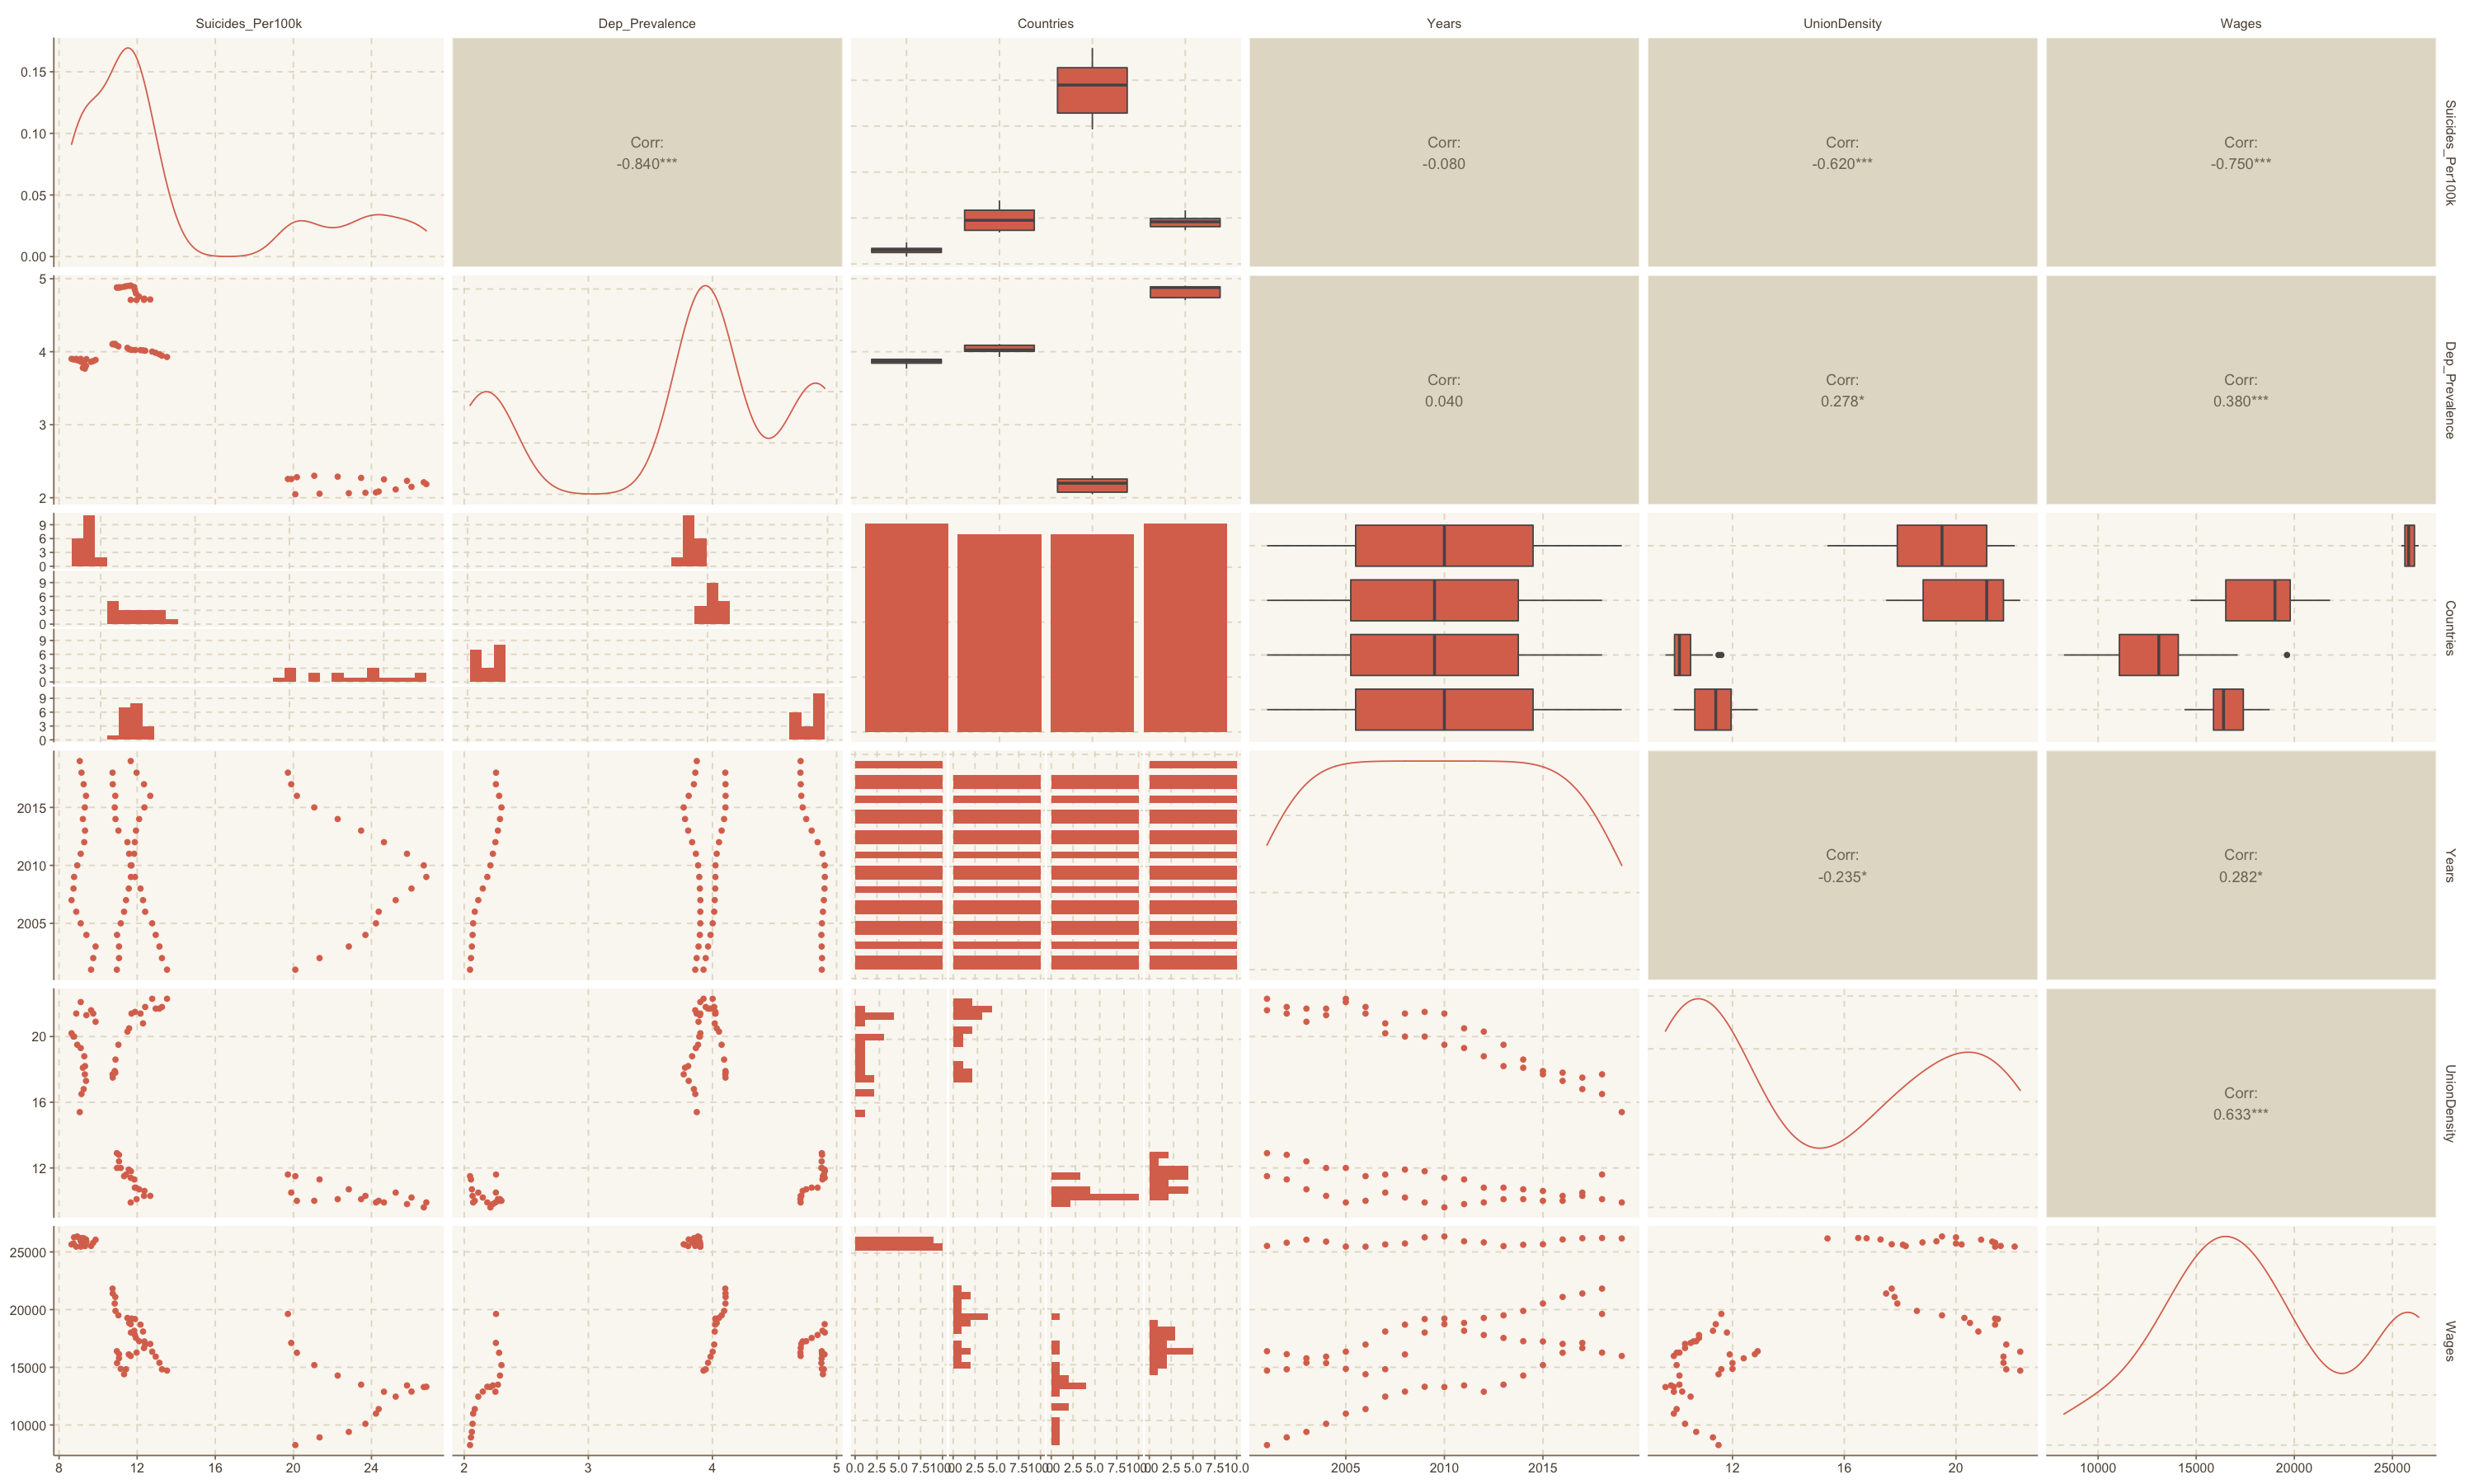

In [14]:
main_df %>% ggpairs(columns = c('Suicides_Per100k', 'Dep_Prevalence', 'Countries', 'Years', 'UnionDensity', 'Wages', 'Hours'))
#Gives us a scatterplot matrix, containing correlations for every relationship between every combination of two variables.
#Very useful for determining which variables are strongly correlated to our response (Suicides per 100k),
#instead of wasting our time plotting many graphs to individually identify these correlations.

In [17]:
#Modelling the Data
#lm() creates linear regresion models, summary() shows their coefficients and effectiveness in explaining the response variable
model1 = lm(Suicides_Per100k ~ Dep_Prevalence + UnionDensity + Wages + Years + Countries, data=main_df)
model2 = lm(Suicides_Per100k ~ Dep_Prevalence + UnionDensity + Wages + Countries, data=main_df)
model3 = lm(Suicides_Per100k ~ Dep_Prevalence + UnionDensity + Wages, data=main_df)
model4 = lm(Suicides_Per100k ~ Dep_Prevalence + UnionDensity, data=main_df)
summary(model1)
summary(model2)
summary(model3)
summary(model4)
#We can see a significant drop in R^2 value when removing those excess regressors - thus we should stick with our original model


Call:
lm(formula = Suicides_Per100k ~ Dep_Prevalence + UnionDensity + 
    Wages + Years + Countries, data = main_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3265 -0.5442  0.0085  0.4277  3.4448 

Coefficients:
                           Estimate   Std. Error t value Pr(>|t|)  
(Intercept)            226.65545745 151.82168531   1.493   0.1402  
Dep_Prevalence          -4.41324893   3.05278157  -1.446   0.1530  
UnionDensity            -0.28582053   0.20122475  -1.420   0.1602  
Wages                   -0.00002588   0.00016953  -0.153   0.8791  
Years                   -0.09663323   0.07302130  -1.323   0.1903  
CountriesNew Zealand     3.53552994   1.78797271   1.977   0.0522 .
CountriesSouth Korea     3.66840891   4.32175727   0.849   0.3990  
CountriesUnited States   4.22432560   4.08353637   1.034   0.3047  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.239 on 66 degrees of freedom
Multiple R-squared:  0.9555,	Adjuste


Call:
lm(formula = Suicides_Per100k ~ Dep_Prevalence + UnionDensity + 
    Wages + Countries, data = main_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3405 -0.4759 -0.0734  0.5085  3.6297 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)   
(Intercept)            26.0834299  8.9069093   2.928  0.00465 **
Dep_Prevalence         -2.6976043  2.7792782  -0.971  0.33523   
UnionDensity           -0.0706953  0.1192613  -0.593  0.55533   
Wages                  -0.0001973  0.0001100  -1.795  0.07722 . 
CountriesNew Zealand    1.7829506  1.2079485   1.476  0.14462   
CountriesSouth Korea    6.3214574  3.8500363   1.642  0.10529   
CountriesUnited States  2.6812803  3.9354070   0.681  0.49802   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.246 on 67 degrees of freedom
Multiple R-squared:  0.9543,	Adjusted R-squared:  0.9502 
F-statistic: 233.4 on 6 and 67 DF,  p-value: < 0.00000000000000022



Call:
lm(formula = Suicides_Per100k ~ Dep_Prevalence + UnionDensity + 
    Wages, data = main_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.2069 -0.6182 -0.0160  0.5372  3.7215 

Coefficients:
                 Estimate Std. Error t value             Pr(>|t|)    
(Intercept)    39.0010065  0.7273915  53.618 < 0.0000000000000002 ***
Dep_Prevalence -3.6863207  0.1714495 -21.501 < 0.0000000000000002 ***
UnionDensity   -0.2383088  0.0417811  -5.704  0.00000025894586730 ***
Wages          -0.0004127  0.0000403 -10.241  0.00000000000000147 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.313 on 70 degrees of freedom
Multiple R-squared:  0.9471,	Adjusted R-squared:  0.9448 
F-statistic: 417.5 on 3 and 70 DF,  p-value: < 0.00000000000000022



Call:
lm(formula = Suicides_Per100k ~ Dep_Prevalence + UnionDensity, 
    data = main_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.2628 -1.4468  0.1858  0.9209  3.8283 

Coefficients:
               Estimate Std. Error t value             Pr(>|t|)    
(Intercept)     37.0527     1.1018   33.63 < 0.0000000000000002 ***
Dep_Prevalence  -4.1697     0.2587  -16.12 < 0.0000000000000002 ***
UnionDensity    -0.4921     0.0528   -9.32   0.0000000000000603 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.06 on 71 degrees of freedom
Multiple R-squared:  0.8678,	Adjusted R-squared:  0.8641 
F-statistic:   233 on 2 and 71 DF,  p-value: < 0.00000000000000022


In [16]:
anova(model1, model2)
anova(model1, model3)
anova(model1, model4)
#Nested ANOVA tests to determine whether there is evidence to suggest a difference in coefficient values for predictors
#in the population when comparing two models. I.e. does one model explain the data differently to another?
#The low p-values suggest that there is a difference.

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,50,0.07649577,NA,NA,NA,NA
2,52,0.45678452,-2,-0.3802887,124.2842,0.00000000000000000003964163


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,50,0.07649577,NA,NA,NA,NA
2,53,0.94122449,-3,-0.8647287,188.4045,0.000000000000000000000000003081695


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,50,0.07649577,NA,NA,NA,NA
2,54,2.20866760,-4,-2.132172,348.4133,0.000000000000000000000000000000000007725756


In [17]:
AIC(model1)
AIC(model2)
AIC(model3)
AIC(model4)
#AIC is a measure of how well the model fits the data, the lower the value - the better the model explains the data.

[1] -196.4477

[1] -100.377

[1] -61.8907

[1] -16.12477

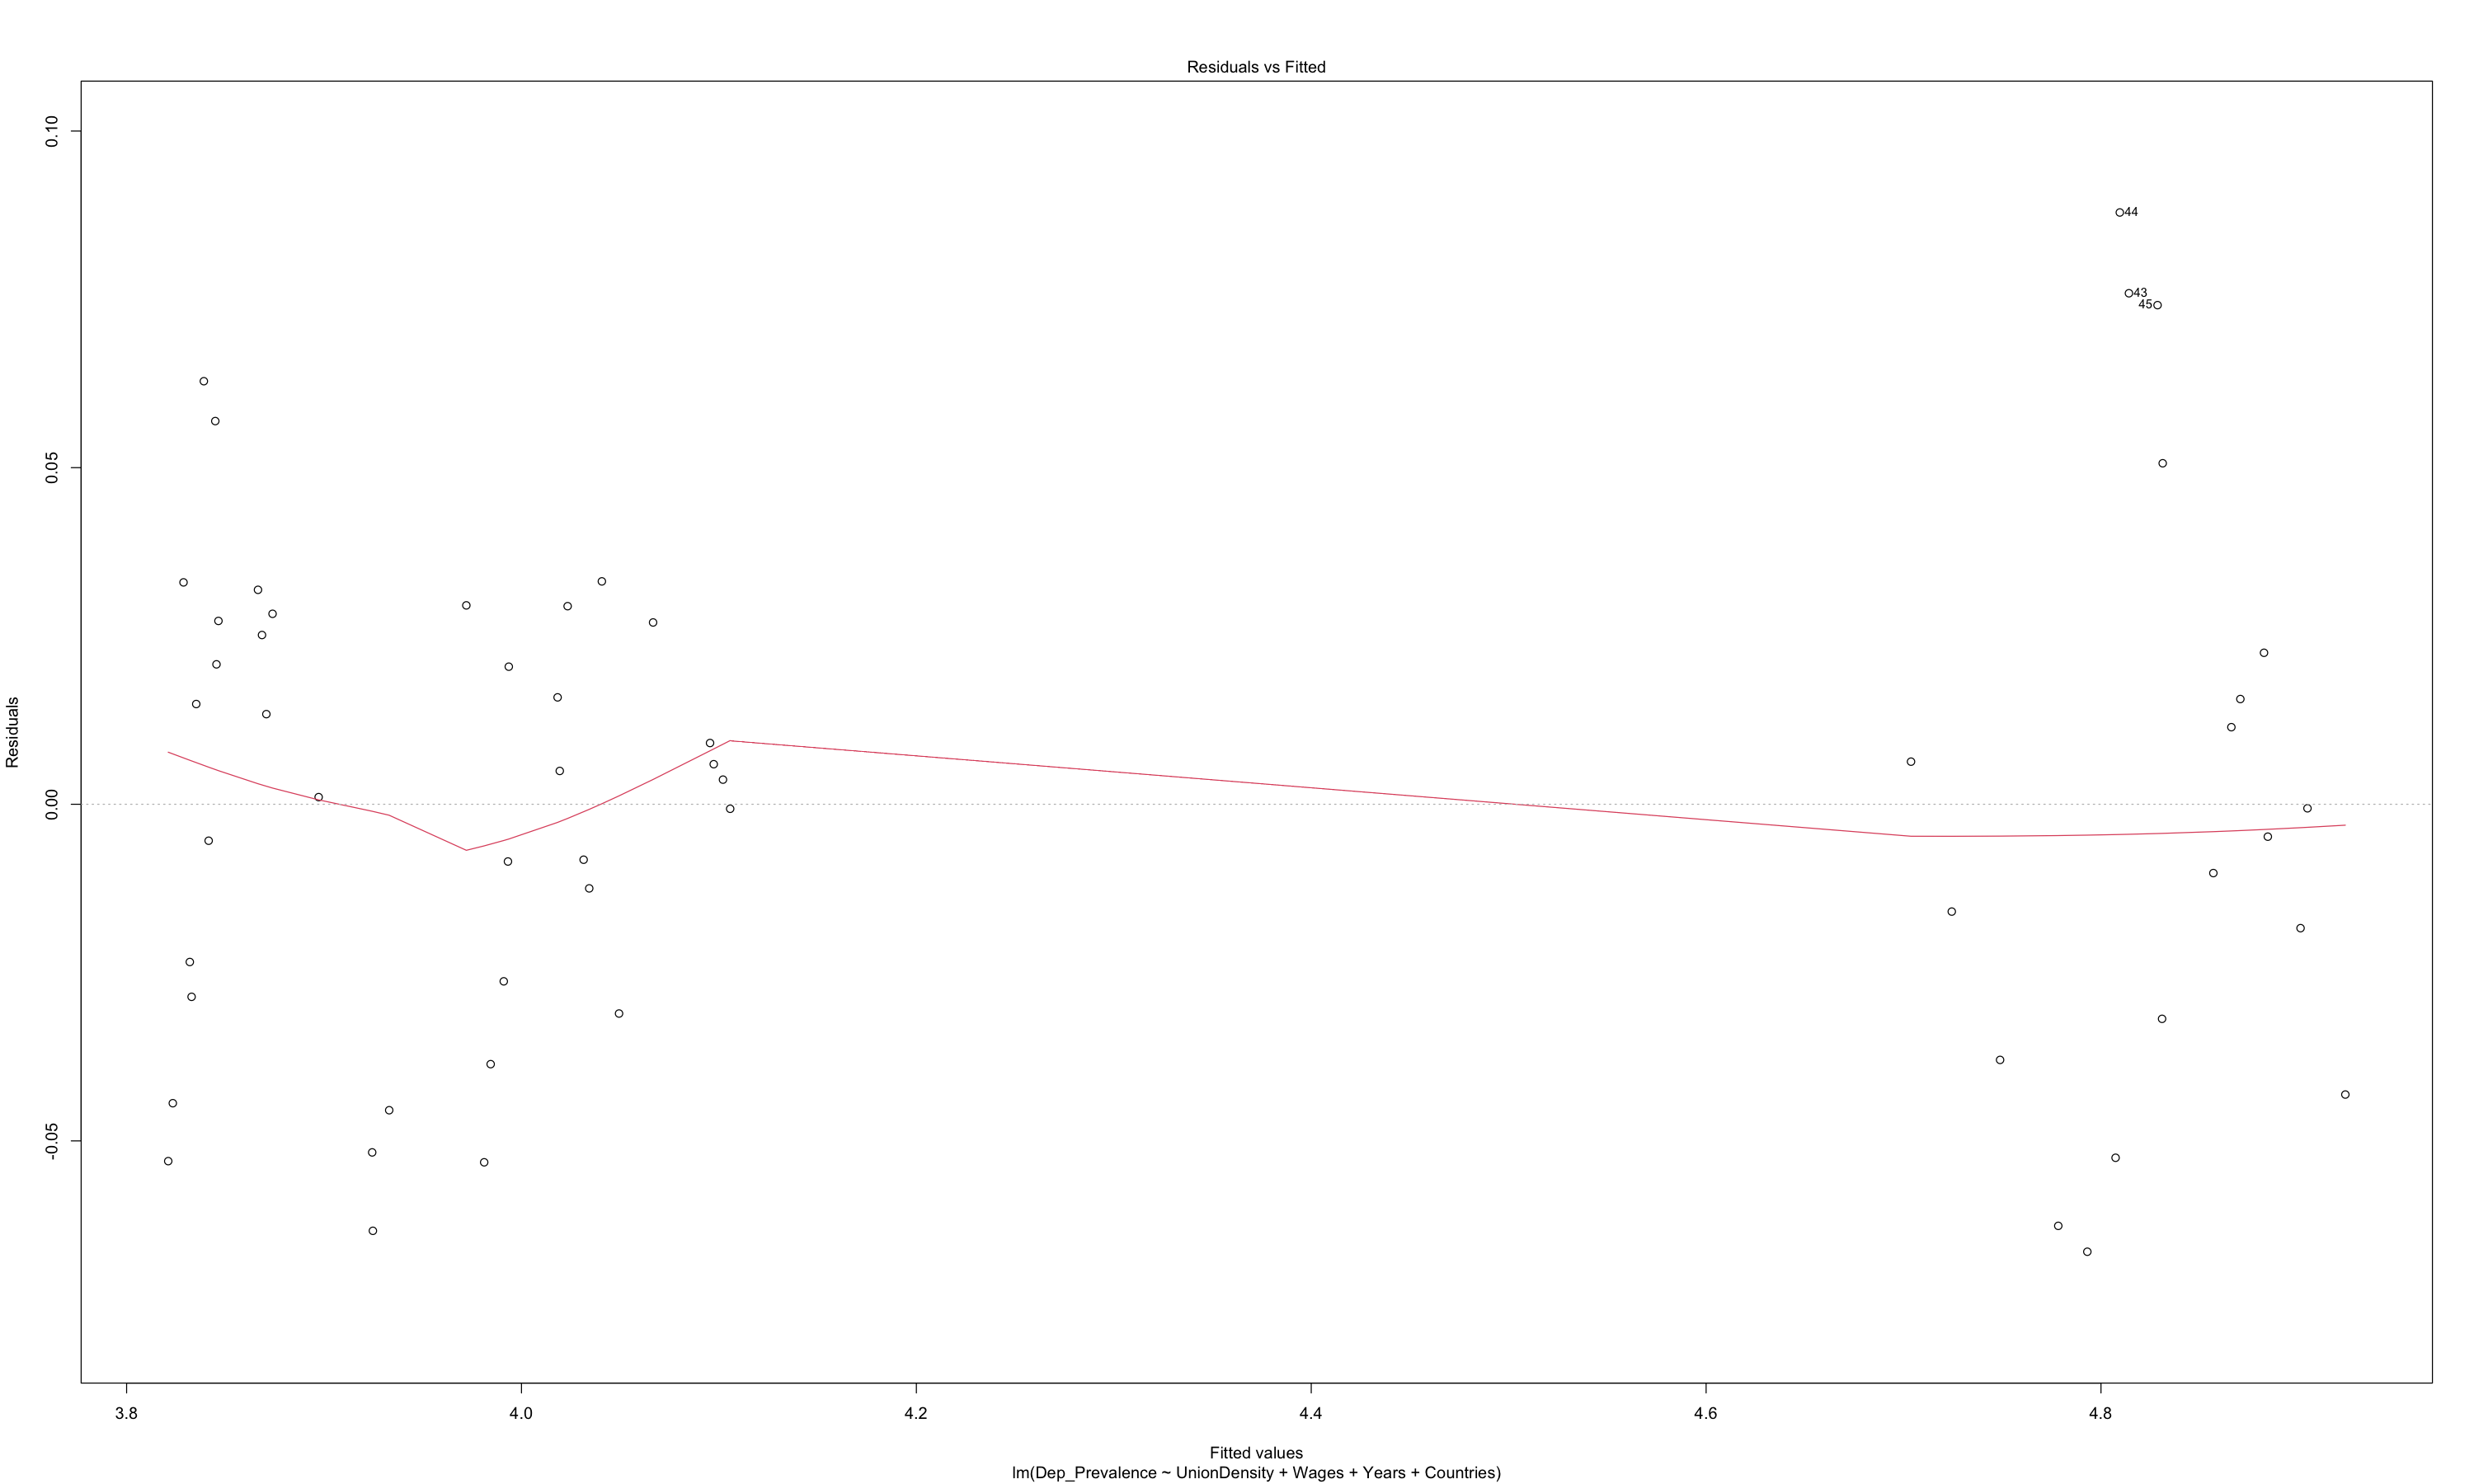

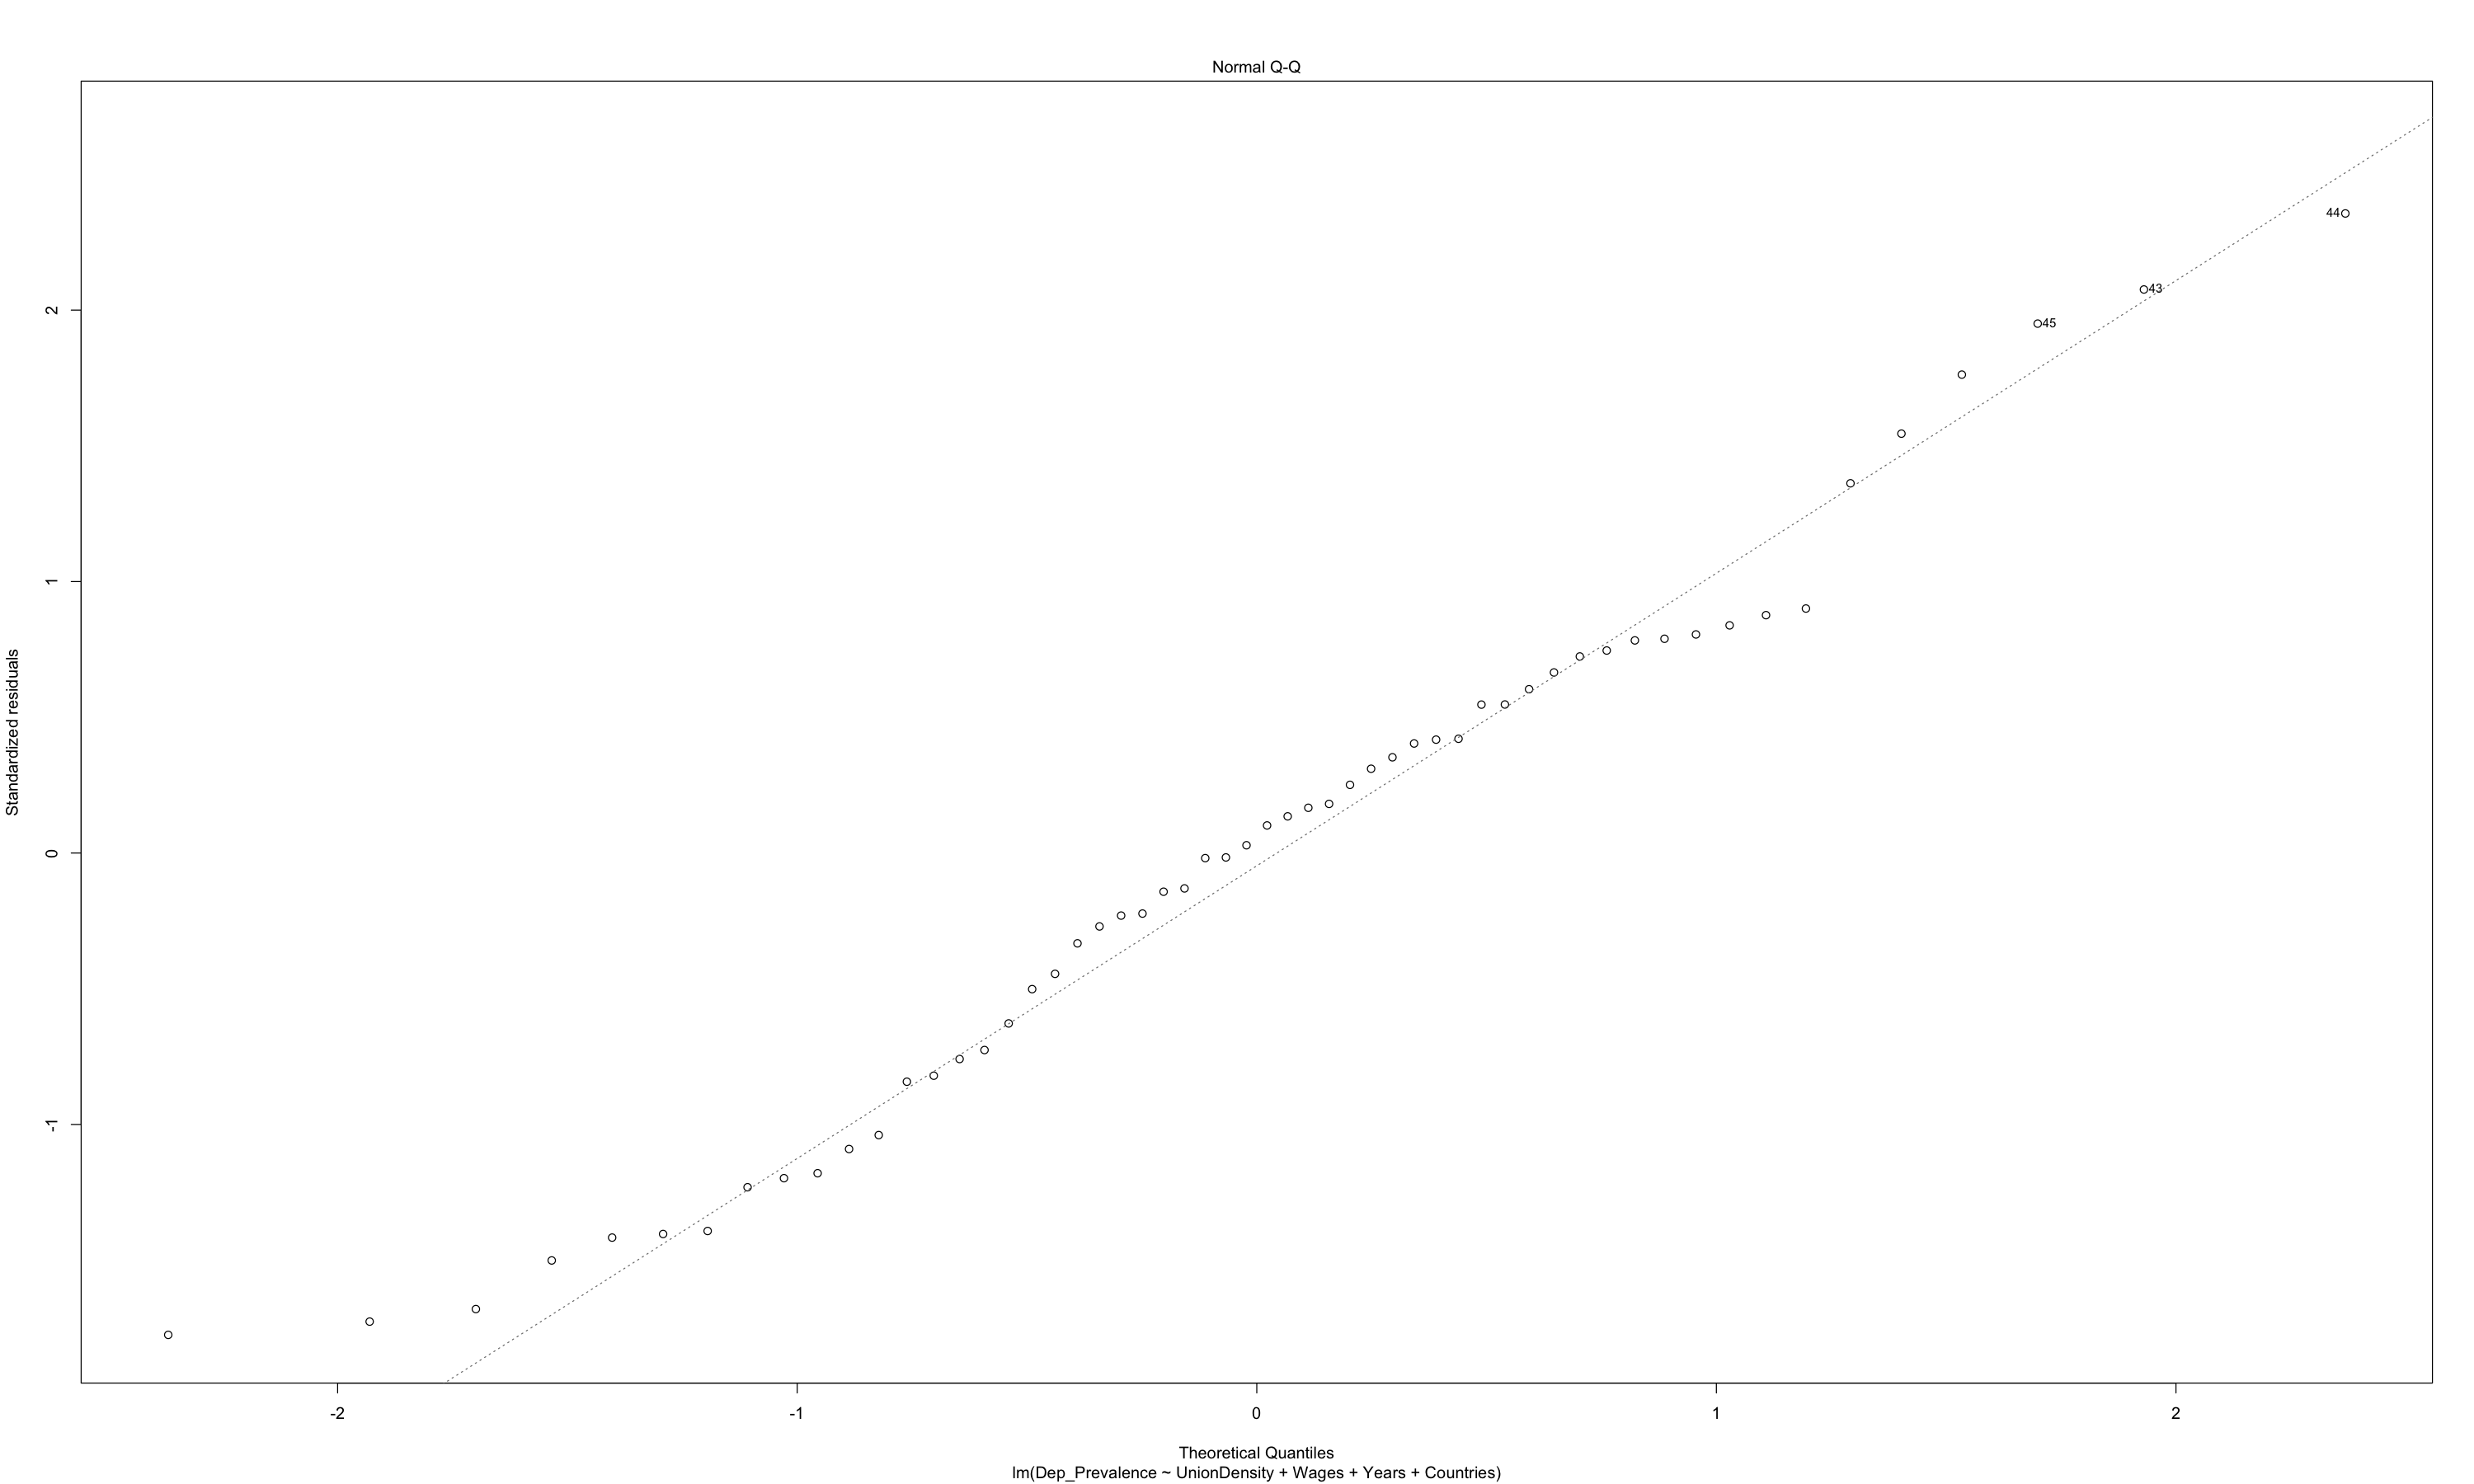

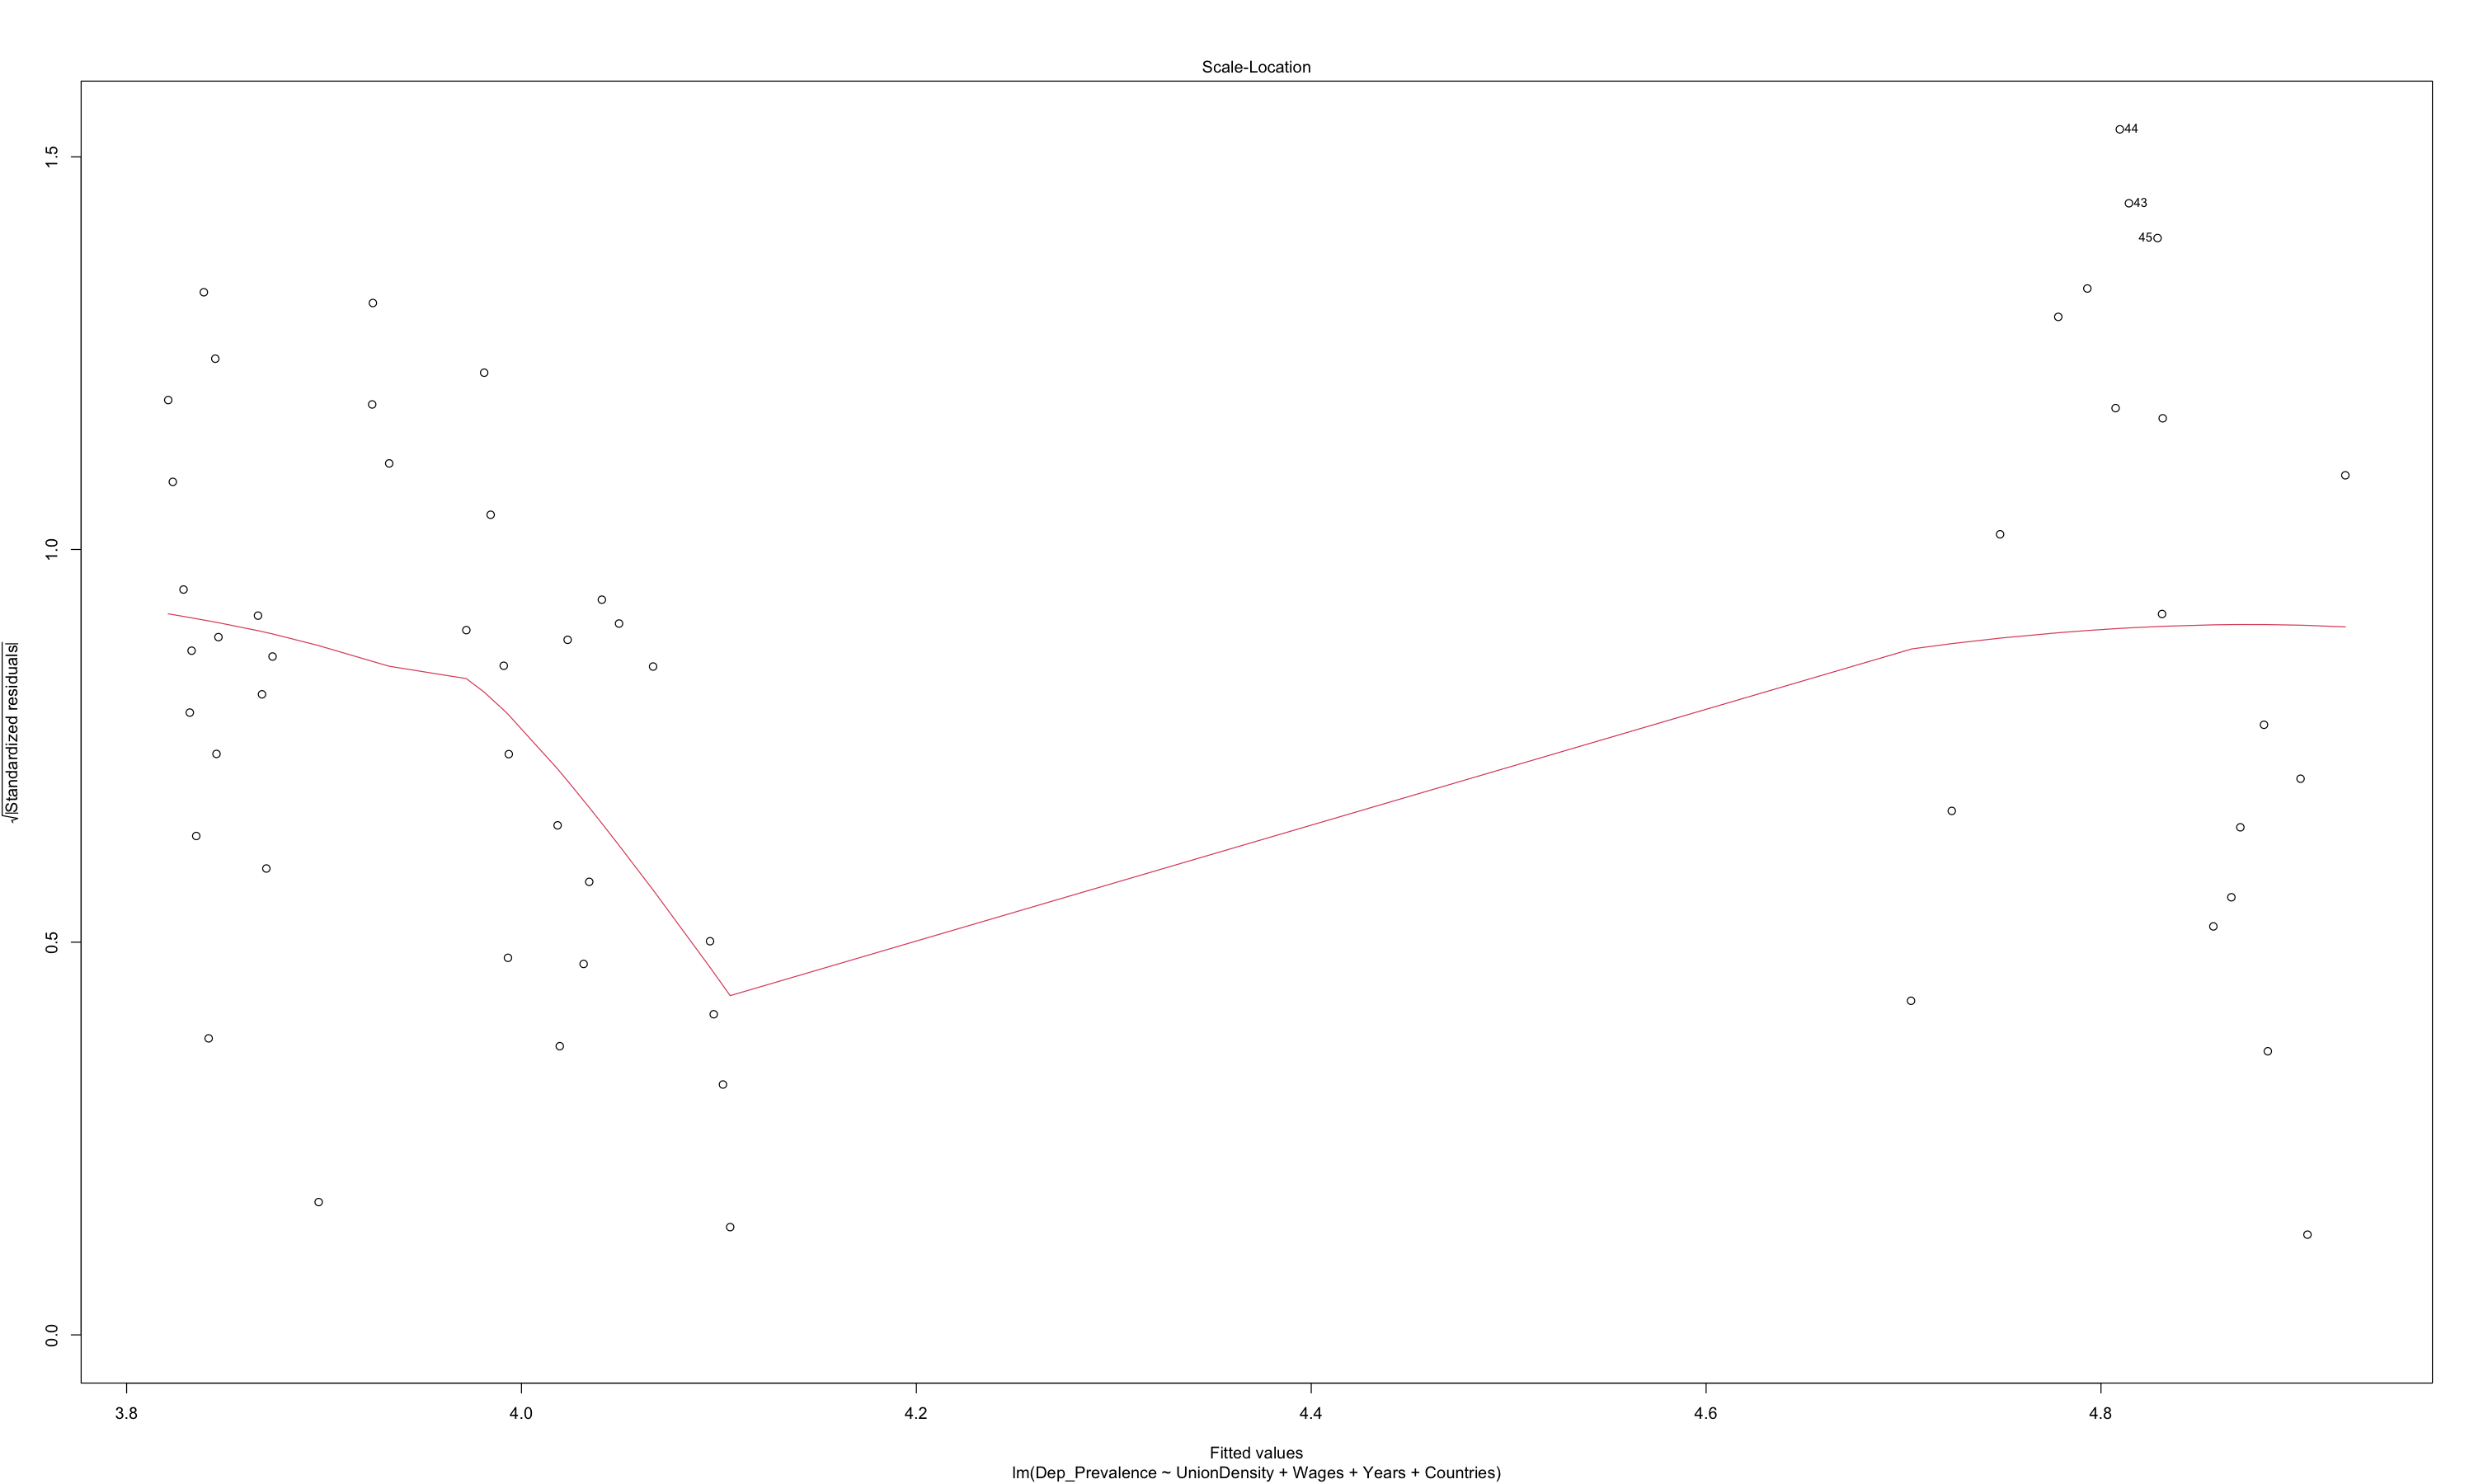

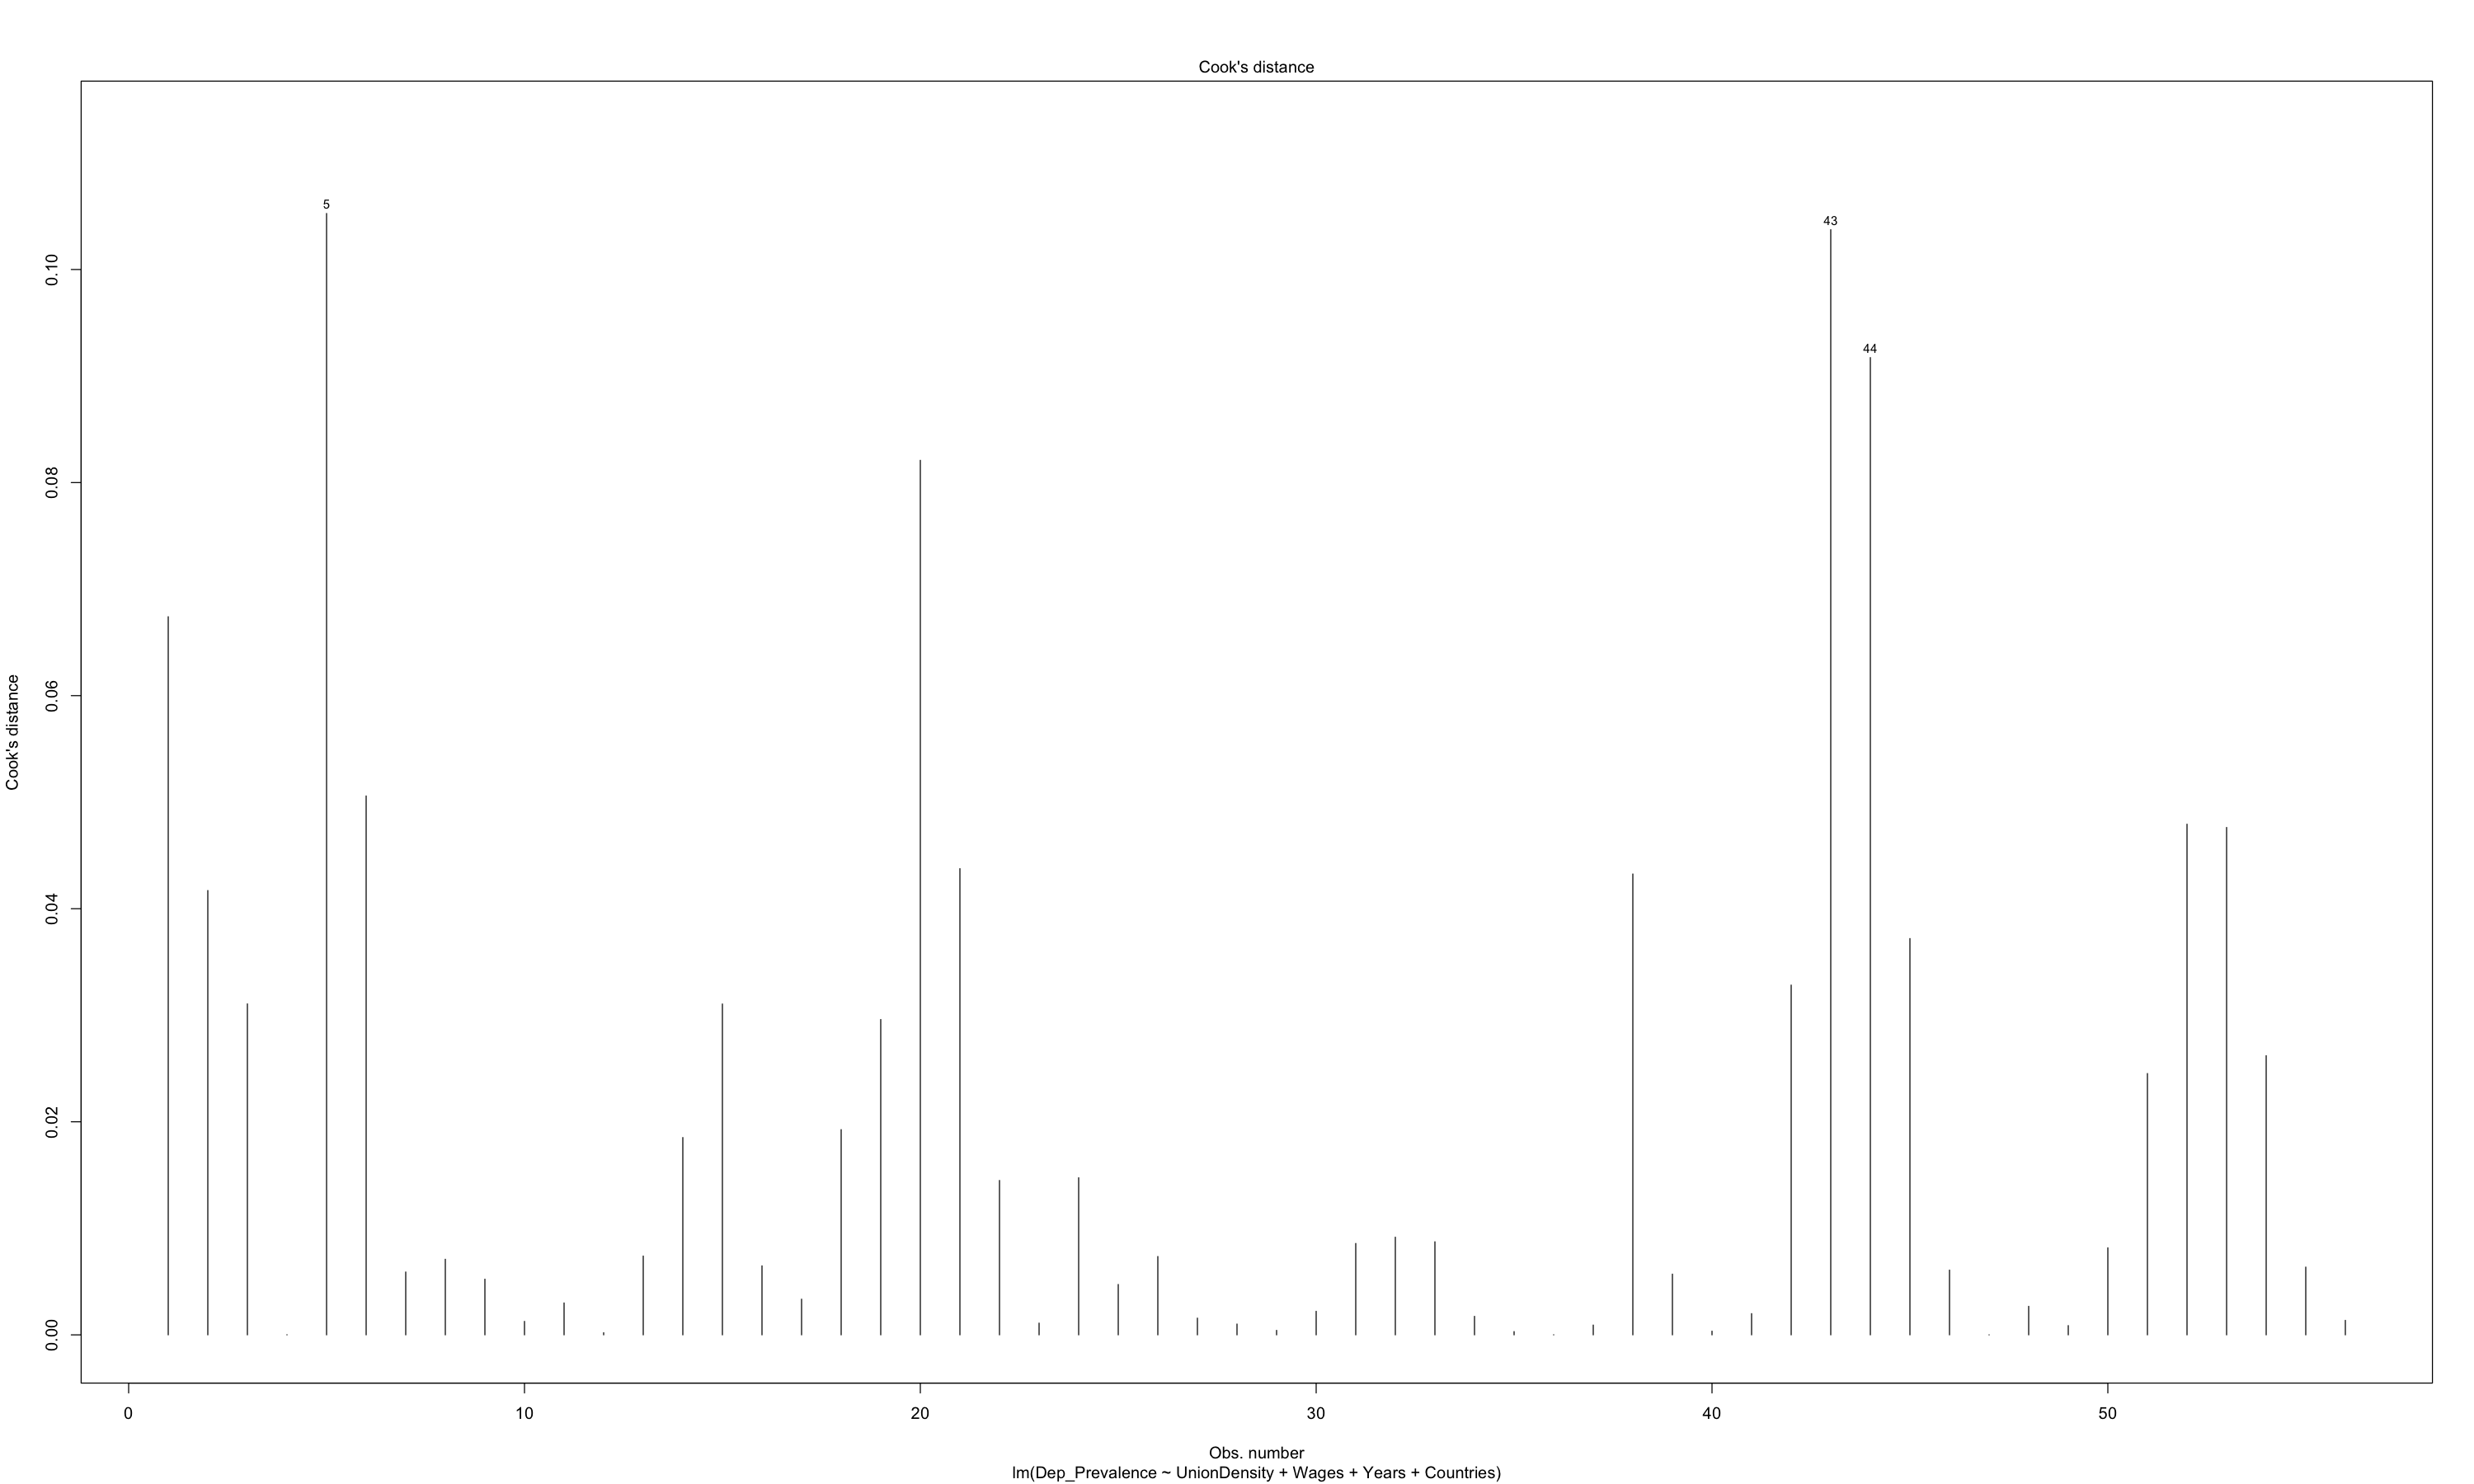

In [61]:
plot(model1, which=1)
plot(model1, which=2)
plot(model1, which=3)
plot(model1, which=4)
#Plots to check assumptions of least squares regression
#Model 1 meets all of these assumptions, thus we are inclined to select it as our chosen model.

In [ ]:
#Conclusions
#Our final model chosen (model 1) explained roughly 95% of the variance in our wrangled dataset. See our report for a brief summary of some of our interesting
#findings - and what they could mean for global policy going forward.
